# Notebook 2 — Simulação multi-bancos (100% offline com CSVs Bacen)

## Célula 1 — Setup (paths, sys.path, reloads)

In [77]:
# Célula 1 — setup e imports
from pathlib import Path
import sys, importlib

# encontra a raiz do projeto (onde há /src e /dados)
ROOT = Path.cwd()
for _ in range(6):
    if (ROOT / "src").is_dir() and (ROOT / "dados").is_dir():
        break
    ROOT = ROOT.parent

SRC = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

print("ROOT:", ROOT)
print("SRC:", SRC)

# recarrega módulos do projeto
import application.controlador as controlador_mod
import infrastructure.data.carregador_IPCA_CSV as ipca_loader_mod
import infrastructure.data.carregador_tr_mensal_CSV as tr_loader_mod

importlib.reload(controlador_mod)
importlib.reload(ipca_loader_mod)
importlib.reload(tr_loader_mod)

from application.controlador import ControladorApp
from infrastructure.data.carregador_IPCA_CSV import carregar_ipca_bacen_csv
from infrastructure.data.carregador_tr_mensal_CSV import carregar_tr_mensal

print("Controlador pronto? simular_multiplos_bancos =", hasattr(ControladorApp, "simular_multiplos_bancos"))



ROOT: c:\Users\edina\SAD-FI
SRC: c:\Users\edina\SAD-FI\src
Controlador pronto? simular_multiplos_bancos = True


## Célula 2 — Monta dados/bancos.csv a partir dos 3 CSVs locais

In [78]:
# Célula 2 — montar bancos.csv a partir dos CSVs (corrigido: usa TaxaJurosAoAno)
import pandas as pd
from pathlib import Path
import unicodedata

TX_DIR = ROOT / "dados" / "txjuros"
CSV_PRE    = TX_DIR / "2025-07P_pre_903101.csv"
CSV_TR_BK  = TX_DIR / "2025-07P_pos_TR_903201.csv"
CSV_IPCA_B = TX_DIR / "2025-07P_pos_IPCA_903203.csv"

caminho_bancos = ROOT / "dados" / "bancos.csv"
caminho_bancos.parent.mkdir(parents=True, exist_ok=True)

def _norm(s: str) -> str:
    s = unicodedata.normalize("NFKD", str(s)).encode("ascii", "ignore").decode("ascii")
    return s.lower().strip()

def _pick_col(cols, *alvos):
    ncols = [_norm(c) for c in cols]
    for alvo in alvos:
        alvo_n = _norm(alvo)
        for i, nc in enumerate(ncols):
            if alvo_n in nc:
                return cols[i]
    return None

def _to_float_series(s):
    x = (s.astype(str)
          .str.replace(".", "", regex=False)   # remove milhar
          .str.replace(",", ".", regex=False)  # vírgula -> ponto
          .str.replace("%", "", regex=False)
          .str.strip())
    return pd.to_numeric(x, errors="coerce")

def _ler_txjuros_csv_corrigido(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, encoding="latin1", sep=";")
    cols = list(df.columns)

    # coluna da instituição
    k_inst = (_pick_col(cols, "instituicao", "instituição", "nome", "instituicao financeira")
              or cols[0])

    # tentar primeiro a ANUAL; se não houver, usar MENSAL e converter
    k_ano = _pick_col(cols, "TaxaJurosAoAno", "taxa ao ano", "a.a")
    k_mes = _pick_col(cols, "TaxaJurosAoMes", "taxa ao mes", "a.m")

    # limpa linhas "Fonte", vazias etc.
    df[k_inst] = df[k_inst].astype(str).str.strip()
    df = df[~df[k_inst].str.contains(r"^fonte", case=False, na=False)]

    if k_ano:
        taxa = _to_float_series(df[k_ano])
        # se veio em %, converte para fração
        if taxa.dropna().median() > 1.0:
            taxa = taxa / 100.0
        taxa_anual = taxa
    elif k_mes:
        tm = _to_float_series(df[k_mes])
        if tm.dropna().median() > 1.0:
            tm = tm / 100.0
        # converte mensal -> anual efetivo
        taxa_anual = (1.0 + tm)**12 - 1.0
    else:
        raise ValueError(f"{path.name}: não encontrei colunas de taxa anual nem mensal. Cabeçalhos: {cols}")

    out = pd.DataFrame({
        "instituicao": df[k_inst].astype(str).str.strip(),
        "taxa_anual": taxa_anual
    }).dropna(subset=["taxa_anual"]).reset_index(drop=True)

    # saneia nomes “Fonte …” que porventura passaram e linhas sem nome
    out = out[out["instituicao"].str.len() > 0]
    out = out[~out["instituicao"].str.contains(r"^fonte", case=False, na=False)]

    # garante fração 0 < x < 1
    out = out[(out["taxa_anual"] > 0.0) & (out["taxa_anual"] < 1.0)]

    # se houver duplicatas por instituição (ex.: múltiplas linhas), fica com a menor taxa
    out["_k"] = out["instituicao"].map(_norm)
    out = (out.sort_values("taxa_anual")
               .drop_duplicates(subset=["_k"], keep="first")
               .drop(columns=["_k"])
               .reset_index(drop=True))
    return out

def _emit(df: pd.DataFrame, sistema: str) -> pd.DataFrame:
    tmp = df.copy()
    tmp["sistema"] = sistema
    tmp = tmp.rename(columns={"instituicao": "nome"})
    return tmp[["nome", "sistema", "taxa_anual"]]

df_pre  = _ler_txjuros_csv_corrigido(CSV_PRE)
df_tr   = _ler_txjuros_csv_corrigido(CSV_TR_BK)
df_ipca = _ler_txjuros_csv_corrigido(CSV_IPCA_B)

bancos_df = pd.concat([
    _emit(df_pre,  "SAC"),
    _emit(df_tr,   "SAC_TR"),
    _emit(df_ipca, "SAC_IPCA"),
], ignore_index=True).sort_values(["nome", "sistema"]).reset_index(drop=True)

# sanity-check final: todas em fração
assert bancos_df["taxa_anual"].between(0, 1).all(), "Há taxa fora de (0,1) — verifique parsing."

bancos_df.to_csv(caminho_bancos, index=False, encoding="utf-8")
print("bancos.csv salvo em:", caminho_bancos, "| linhas:", len(bancos_df))
display(bancos_df.head(12))


bancos.csv salvo em: c:\Users\edina\SAD-FI\dados\bancos.csv | linhas: 23


,nome,sistema,taxa_anual
0,APE POUPEX,SAC,0.1799
1,APE POUPEX,SAC_TR,0.1166
2,BANCO BARI S.A.,SAC_IPCA,0.1668
3,BANCO BARI S.A.,SAC_TR,0.0799
4,BANCO INTER,SAC_TR,0.1224
5,BANCO SEMEAR,SAC_IPCA,0.0938
6,BANCO SICOOB S.A.,SAC_TR,0.1126
7,BARI CIA HIPOTECÃRIA,SAC_IPCA,0.1680
8,BCO BRADESCO S.A.,SAC_TR,0.1290
9,BCO COOPERATIVO SICREDI S.A.,SAC_TR,0.1186


## Célula 3 — TR mensal (a partir do CSV diário)

In [79]:
# Célula 3 — TR: diária -> mensal usando seu carregador
CSV_TR_SERIE = ROOT / "dados" / "txjuros" / "TR_BACEN.csv"

tabela_tr_mensal = carregar_tr_mensal(
    path_csv=CSV_TR_SERIE,
    fill_missing=True,   # útil para cobrir meses sem publicação explícita
    start=None,          # ex.: "2010-01"
    end=None,            # ex.: "2025-07"
)

print("TR (mensal) — meses:", len(tabela_tr_mensal))
display(tabela_tr_mensal.head(6))
display(tabela_tr_mensal.tail(6))

# OBS: o Controlador consumirá o CSV BRUTO (fixture_csv_path), porque é isso que ele espera.
print("Controlador consumirá TR de:", CSV_TR_SERIE)

# >>> ADICIONE ao fim da Célula 3 <<<
# Gera um CSV compatível com TabelaTR (colunas: data,tr ; separador vírgula; ponto decimal)
TR_COMPAT = ROOT / "dados" / "txjuros" / "TR_mensal_compat.csv"
tabela_tr_mensal.to_csv(TR_COMPAT, index=False, encoding="utf-8")  # sep=',' padrão; dec='.' padrão
print("TR compat salvo em:", TR_COMPAT)


TR (mensal) — meses: 373


,data,tr
0,1994-08,0.024597
1,1994-09,0.025850
2,1994-10,0.030661
3,1994-11,0.028787
4,1994-12,0.020048
5,1995-01,0.020949


,data,tr
367,2025-03,0.001708
368,2025-04,0.001711
369,2025-05,0.001699
370,2025-06,0.001739
371,2025-07,0.001742
372,2025-08,0.001742


Controlador consumirá TR de: c:\Users\edina\SAD-FI\dados\txjuros\TR_BACEN.csv
TR compat salvo em: c:\Users\edina\SAD-FI\dados\txjuros\TR_mensal_compat.csv


## Célula 4 — IPCA (a partir do CSV Bacen) 

In [80]:
# Célula 4 — IPCA: usa seu carregador para higienizar/inspecionar (mas o controlador lerá do CSV bruto)
CSV_IPCA_SERIE = ROOT / "dados" / "txjuros" / "IPCA_BACEN.csv"

df_ipca = carregar_ipca_bacen_csv(CSV_IPCA_SERIE)
print("IPCA (meses):", len(df_ipca))
display(df_ipca.head(8))

# OBS: o Controlador vai apontar para o CSV BRUTO via 'caminho_ipca'
print("Controlador consumirá IPCA de:", CSV_IPCA_SERIE)


IPCA (meses): 372


,data,ipca
0,1994-08,1.86
1,1994-09,1.53
2,1994-10,2.62
3,1994-11,2.81
4,1994-12,1.71
5,1995-01,1.70
6,1995-02,1.02
7,1995-03,1.55


Controlador consumirá IPCA de: c:\Users\edina\SAD-FI\dados\txjuros\IPCA_BACEN.csv


## Célula 5 — Parâmetros e fontes para o Controlador

In [81]:
# Célula 5 — parâmetros do financiamento e fontes (paths brutos, como o Controlador espera)
dados = {
    "valor_total": 300_000.00,
    "entrada":     60_000.00,
    "prazo_anos":  30,
    "taxa_juros_anual": 0.11,
}

# Controlador atual aceita:
#  - IPCA: {"caminho_ipca": <caminho para CSV>}
#  - TR:   {"fixture_csv_path": <caminho para CSV>}  (ou online, que não usaremos)
fonte_ipca = {"caminho_ipca": str(CSV_IPCA_SERIE)}
fonte_tr   = {"fixture_csv_path": str(TR_COMPAT)} 

print("Prazo (anos):", dados["prazo_anos"])
print("Usando IPCA CSV bruto:", fonte_ipca["caminho_ipca"])
print("Usando TR   CSV bruto:", fonte_tr["fixture_csv_path"])


Prazo (anos): 30
Usando IPCA CSV bruto: c:\Users\edina\SAD-FI\dados\txjuros\IPCA_BACEN.csv
Usando TR   CSV bruto: c:\Users\edina\SAD-FI\dados\txjuros\TR_mensal_compat.csv


## Célula 6 — Executa simulação multi-bancos

In [82]:
# Célula 6 — rodando a simulação
import importlib, application.controlador as controlador_mod
importlib.reload(controlador_mod)
from application.controlador import ControladorApp

ctrl = ControladorApp()
resultados, ranking, mensagem = ctrl.simular_multiplos_bancos(
    caminho_bancos_csv=str(caminho_bancos),
    dados_financiamento=dados,
    fonte_ipca=fonte_ipca,
    fonte_tr=fonte_tr,
)

print("Ranking (top 15):")
for i, (rotulo, total) in enumerate(ranking[:15], 1):
    print(f"{i:02d}. {rotulo} — total pago: R$ {total:,.2f}")

print("\nRecomendação:", mensagem)


      Data  \
0  08/1994   
1  09/1994   
2  10/1994   
3  11/1994   
4  12/1994   

  433 - Índice nacional de preços ao consumidor-amplo (IPCA) - Var. % mensal  
0                                               1,86                          
1                                               1,53                          
2                                               2,62                          
3                                               2,81                          
4                                               1,71                          
Ranking (top 15):
01. CAIXA ECONOMICA FEDERAL – SAC — total pago: R$ 615,428.91
02. BCO SANTANDER (BRASIL) S.A. – SAC — total pago: R$ 785,420.00
03. APE POUPEX – SAC — total pago: R$ 841,336.61
04. BANCO BARI S.A. – SAC TR — total pago: R$ 1,149,763.82
05. BCO DO ESTADO DO RS S.A. – SAC TR — total pago: R$ 1,297,667.58
06. BCO DO EST. DE SE S.A. – SAC TR — total pago: R$ 1,357,781.12
07. CAIXA ECONOMICA FEDERAL – SAC TR — total pago: R$

## Célula 7 — Exporta CSV + gráfico

CSV salvo em: c:\Users\edina\SAD-FI\resultados\ranking.csv


C:\Users\edina\AppData\Local\Temp\ipykernel_31712\2545317944.py:24: UserWarning: Glyph 154 (\x9a) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\edina\AppData\Local\Temp\ipykernel_31712\2545317944.py:25: UserWarning: Glyph 154 (\x9a) missing from font(s) DejaVu Sans.
  plt.savefig(png_path, dpi=150)
c:\Users\edina\SAD-FI\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 154 (\x9a) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


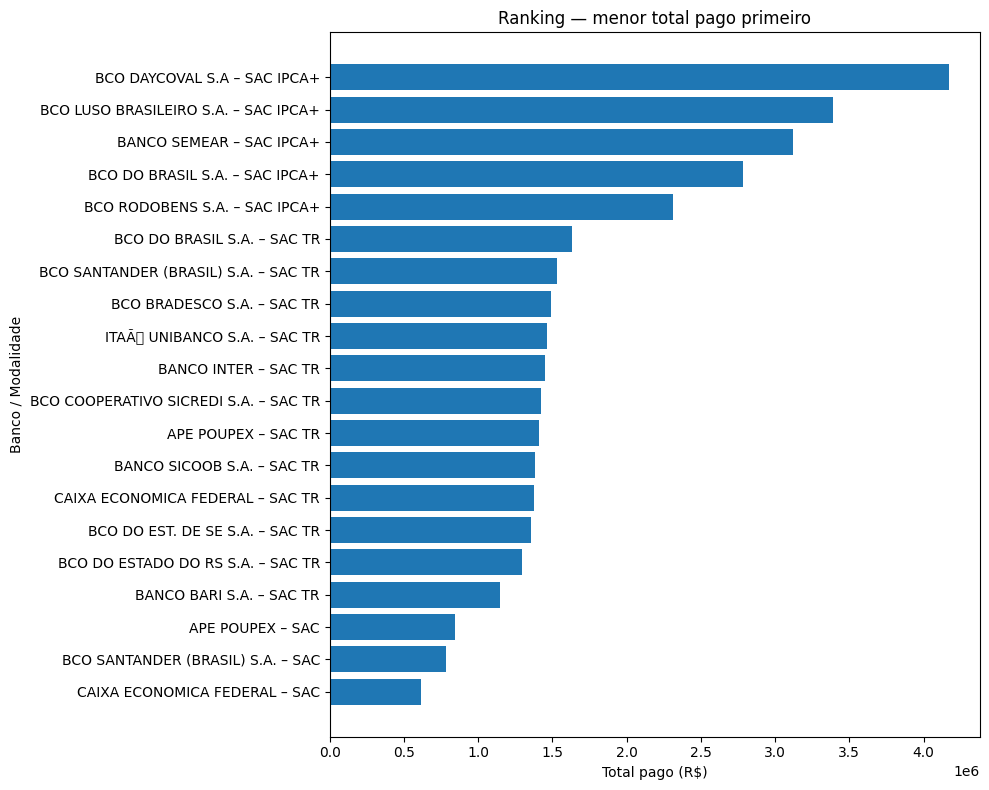

PNG salvo em: c:\Users\edina\SAD-FI\resultados\graficos\ranking.png


In [83]:
# Célula 7 — exportar ranking e gráfico
import pandas as pd
import matplotlib.pyplot as plt

df_rank = pd.DataFrame(ranking, columns=["rotulo", "total_pago"])

out_dir = ROOT / "resultados"
graf_dir = out_dir / "graficos"
out_dir.mkdir(parents=True, exist_ok=True)
graf_dir.mkdir(parents=True, exist_ok=True)

csv_path = out_dir / "ranking.csv"
png_path = graf_dir / "ranking.png"

df_rank.to_csv(csv_path, index=False, encoding="utf-8")
print("CSV salvo em:", csv_path)

df_plot = df_rank.sort_values("total_pago", ascending=True).head(20)
plt.figure(figsize=(10, max(6, 0.4*len(df_plot))))
plt.barh(df_plot["rotulo"], df_plot["total_pago"])
plt.xlabel("Total pago (R$)")
plt.ylabel("Banco / Modalidade")
plt.title("Ranking — menor total pago primeiro")
plt.tight_layout()
plt.savefig(png_path, dpi=150)
plt.show()

print("PNG salvo em:", png_path)
